In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
base_path = './dataset-landmark'

train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')
validation_path = os.path.join(base_path, 'valid')

Classes: ['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']
Number of classes: 6
Found 11224 images belonging to 6 classes.
Found 2810 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


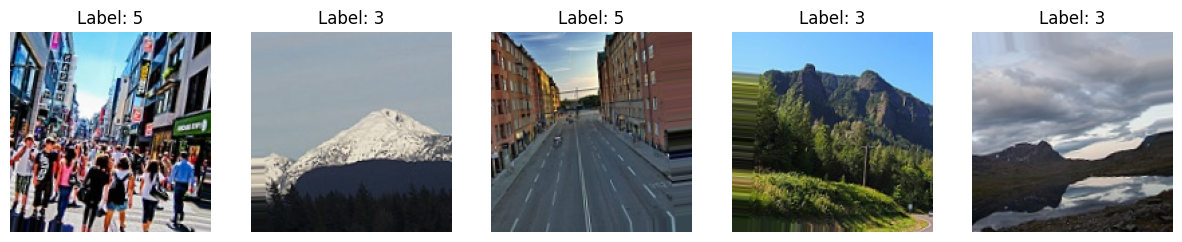

In [4]:
image_size = (150, 150)
batch_size = 64
channels = 3

# Get classes
classes = os.listdir(train_path)
print(f'Classes: {classes}')
num_classes = len(classes)
print(f'Number of classes: {num_classes}')

# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
)

validation_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
)
test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
)

train_dataset = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

validation_dataset = validation_datagen.flow_from_directory(
    validation_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_dataset = test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Visualize processed images
def visualize_images(dataset, num_images=5):
    plt.figure(figsize=(15, 5))
    images, labels = next(dataset)

    images = np.clip(images, 0, 1)
    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {np.argmax(labels[i])}')
        plt.axis('off')
    plt.show()

visualize_images(train_dataset)

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

base_model.trainable = False

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) 
output = Dense(num_classes, activation='softmax')(x) 

# Crear el modelo final
vgg_model = Model(inputs=base_model.input, outputs=output)

# Resumen del modelo
vgg_model.summary()

vgg_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,980,422 (57.15 MB)

 Trainable params: 265,734 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Entrenar el modelo
history = vgg_model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    steps_per_epoch=train_dataset.samples // batch_size,
    validation_steps=validation_dataset.samples // batch_size
)

Epoch 1/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1138s 7s/step - accuracy: 0.5941 - loss: 1.0144 - val_accuracy: 0.8259 - val_loss: 0.4785
Epoch 2/50
  1/175 ━━━━━━━━━━━━━━━━━━━━ 14:55 5s/step - accuracy: 0.8438 - loss: 0.3635

/Users/danielhurtado/Library/CloudStorage/GoogleDrive-a01707774@tec.mx/My Drive/Tec/FJ25/IA/.venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


175/175 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.8438 - loss: 0.3635 - val_accuracy: 0.8256 - val_loss: 0.4741
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1072s 6s/step - accuracy: 0.8015 - loss: 0.5192 - val_accuracy: 0.8459 - val_loss: 0.4189
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.8281 - loss: 0.4623 - val_accuracy: 0.8452 - val_loss: 0.4166
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 893s 5s/step - accuracy: 0.8215 - loss: 0.4735 - val_accuracy: 0.8536 - val_loss: 0.3946
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.8281 - loss: 0.4680 - val_accuracy: 0.8561 - val_loss: 0.3905
Epoch 7/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 900s 5s/step - accuracy: 0.8373 - loss: 0.4365 - val_accuracy: 0.8499 - val_loss: 0.3969
Epoch 8/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 172s 967ms/step - accuracy: 0.8438 - loss: 0.4236 - val_accuracy: 0.8517 - val_loss: 0.3972
Epoch 9/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 938s 5s/step - accuracy: 0.8416 - loss: 0.4170 - val_accuracy: 0

In [12]:
# Evaluar en el conjunto de prueba
test_loss, test_accuracy = vgg_model.evaluate(test_dataset)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

47/47 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.8882 - loss: 0.2997
Test Loss: 0.3265
Test Accuracy: 0.8747


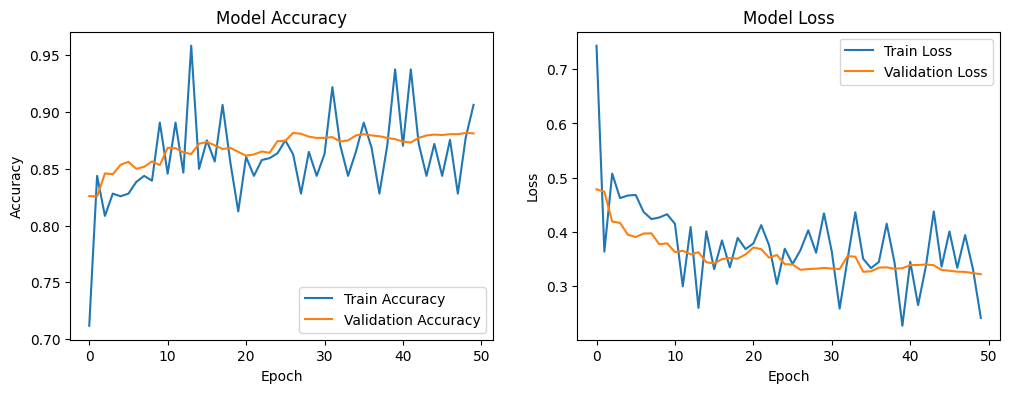

In [13]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [14]:
def get_predictions(dataset, model):
    y_true = dataset.classes
    y_pred = model.predict(dataset, verbose=0)
    y_pred = np.argmax(y_pred, axis=1)
    return y_true, y_pred

y_true, y_pred = get_predictions(test_dataset, vgg_model)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

      forest       0.89      0.89      0.89       437
   buildings       0.98      0.97      0.98       474
     glacier       0.78      0.87      0.82       553
      street       0.87      0.75      0.81       525
    mountain       0.88      0.86      0.87       510
         sea       0.89      0.91      0.90       501

    accuracy                           0.87      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.87      0.87      3000



<Figure size 1000x800 with 0 Axes>

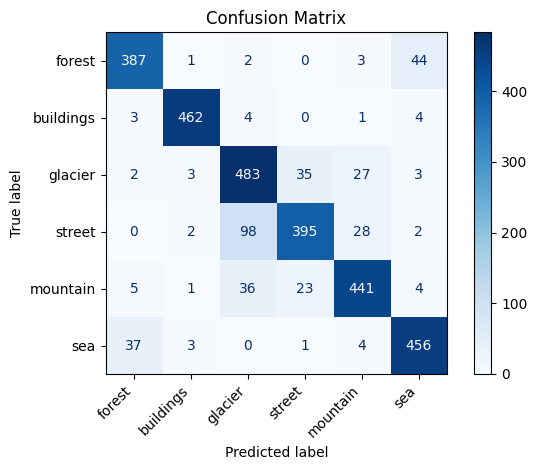

In [15]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)

    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    
    plt.figure(figsize=(10, 8))
    cm_display.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes)